In [2]:
%pip install torchdiffeq

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from functools import partial
from torch.autograd.functional import jacobian, hessian

from torchdiffeq import odeint as tor_odeint
from torchdiffeq import odeint_adjoint as tor_odeintadj
torch.version.__version__

'2.1.2'

Lagrangian for spring pendulum, in 2D, with $r$ spring length, $\theta$ angle from vertical: 

$\mathcal{L} = T - V = \frac{1}{2}\dot{r}^2 + \frac{1}{2} r^2\dot{\theta}^2 - gr(1-\cos(\theta)) - k(r -r_0)^2$

By applying Euler Lagrange equations get:

$\ddot r = r\dot{\theta}^2 + g(1-\cos(\theta)) - 2k(r-r_0)$

and 

$\ddot \theta = -\frac{1}{r}(g\sin(\theta) + 2\dot{r}\dot{\theta})$

can use these and `odeint` to solve analytically.



In [4]:
class constant_force:
    
    def __init__(self, m, g):
        self.m = m
        self.g = g
        self.dof = 2
        self.toy_position_example = np.array([3.0])
        self.toy_velocity_example = np.array([10])
        self.toy_time_dataset = np.arange(0, 5, 0.005)
        
    def kinetic(self, x):
        return 0.5 * self.m * x[1]**2
    
    def potential(self, x):
        return self.m * self.g * x[0]
    
    # NEED LAGRANGIAN TO PRODUCE SCALARS, NOT TENSORS!
    def lagrangian(self, x):
        T = self.kinetic(x)
        V = self.potential(x)
        return T - V

    def energy(self, x):
        T = self.kinetic(x)
        V = self.potential(x)
        return T + V
    
    def solve_acceleration(self, q, qdot):
        return -self.g
    
    def plot_solved_dynamics(self, t, path, labelstr = ""):
        plt.plot(t, path[:, 0], label = labelstr)
        
    def plot_lagrangian(self, t, path, lagrangian, labelstr = ""):
        plt.plot(t, [lagrangian(l) for l in path], label = labelstr)



In [5]:
class spring_pendulum:
    
    def __init__(self, k, g):
        self.k = k
        self.g = g
        self.dof = 4
        self.toy_position_example = np.array([1.1, 0.5])
        self.toy_velocity_example = np.array([0.0, 0.0])
        self.toy_time_dataset = np.arange(0, 5, 0.005)
        
    def kinetic(self, q, qt):
        return 0.5*(qt[0]**2 + (q[0]*qt[1])**2)
    
    def potential(self, q, qt, cos):
        return self.g*q[0]*(1-cos(q[1])) + self.k*(q[0] - 1)**2
    
    # NEED LAGRANGIAN TO PRODUCE SCALARS, NOT TENSORS!
    def lagrangian(self, x):
        q, qt = torch.split(x, 2)
        T = self.kinetic(q, qt)
        V = self.potential(q, qt, torch.cos)
        return T - V

    def energy(self, x):
        try:
            q, qt = torch.split(x, self.dof//2)
            cos = torch.cos
        except: 
            q, qt = np.split(x, self.dof//2)
            cos = np.cos
        T = self.kinetic(q, qt)
        V = self.potential(q, qt, cos)
        return T + V
    
    def solve_acceleration(self, q, qdot):
        '''
        q is [r, theta]
        qdot is [rdot, thetadot]

        returns q double dot.
        '''
        qdtt = np.zeros_like(q)
        
        qdtt[:, 0] = q[:, 0]*qdot[:, 1]**2 - self.g*(1-np.cos(q[:, 1])) - 2*self.k*(q[:, 0]-1) 
        qdtt[:, 1] = (-self.g*np.sin(q[:, 1]) -2*qdot[:, 0]*qdot[:, 1])/q[:, 0]

        return qdtt  
    
    def polar_to_cartesian(self, ql):
        '''
        Polar coords to xy
        '''
        try: 
            xy = np.zeros_like(ql)
            sin = np.sin
            cos = np.cos
        except: 
            xy = torch.zeros_like(ql)
            sin = torch.sin
            cos = torch.cos

        xy[:, 0] = ql[:, 0]*sin(ql[:, 1])
        xy[:, 1] = -ql[:, 0]*cos(ql[:, 1])
        return xy
    
    def plot_solved_dynamics(self, t, path, labelstr = ""):
        xy = self.polar_to_cartesian(path)
        plt.plot(xy[:, 0], xy[:, 1], label = labelstr)
    

In [6]:
trial = 0

if (trial == 0):
    particle = constant_force(1, 5)
elif (trial == 1):
    particle = spring_pendulum(10,10)

In [7]:
def get_qdotdot(total_state, analytical_solution):
    '''
    total_state is a tensor of generalised coords and velocities,
    returns q double dot.
    '''
    dims = total_state.shape[1]
    if dims%2 != 0:
        raise ValueError("The input total_state must have an even number of columns.")
    return analytical_solution(total_state[:, :dims//2], total_state[:, dims//2:])


# Returns q_dot and q_dotdot 

#Want to make these functions as general as possible. so that they can be used for any system.

def analytically_differentiated_state(x, t, analytical_solution):
    d = np.zeros_like(x)
    
    #Remove 2's, make it general
    n_cols = x.shape[1]
    if n_cols % 2 != 0:
        raise ValueError("The input x must have an even number of columns.")
    d[:, :n_cols//2] = x[:, n_cols//2:]
    d[:, n_cols//2:] = get_qdotdot(x, analytical_solution)
    return d


# This takes only 4 numbers: the starting position and velocity. 
# f_analytic function returns q_dot and q_dotdot for 1 dimensional inputs.

# Returns:
# An array containing the value of y for each desired time in t, with the initial value y0 in the first row.


def ode_solve_analytic(q0, qt0, t, analytical_solution):

    x0 = np.append(q0, qt0)

    def f_analytic(x, t):
        d = np.zeros_like(x)
        n_cols = x.shape[0]
        d[:n_cols//2] = x[n_cols//2:]
        d[n_cols//2:] = np.squeeze(get_qdotdot(np.expand_dims(x, axis=0), analytical_solution))
        # print(x, d)
        return d
    
    return odeint(f_analytic, x0, t, rtol=1e-10, atol=1e-10)
    



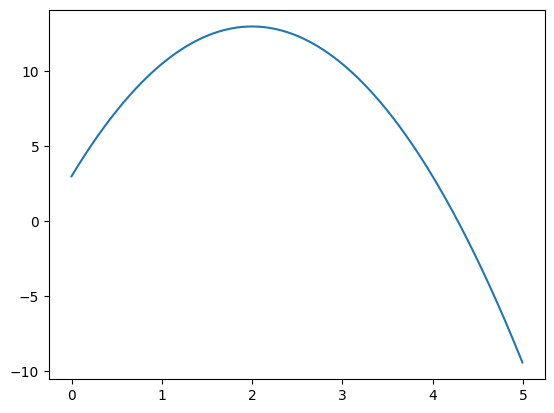

In [8]:
t = particle.toy_time_dataset
q0 = particle.toy_position_example
qt0 = particle.toy_velocity_example

path = ode_solve_analytic(q0, qt0, t, particle.solve_acceleration)

particle.plot_solved_dynamics(t, path)

We can also solve using pytorch to autodiff the lagrangian, an use the following version of the EL equations (after Cranmer et al.), with $q=(r, \theta)$:

$\ddot q = (\nabla_{\dot q}\nabla_{\dot q}^{\top}\mathcal{L})^{-1}[\nabla_q \mathcal{L} - (\nabla_{q}\nabla_{\dot q}^{\top}\mathcal{L})\dot q]$





In [9]:
# Gets the q_dot, q_dotdot by differentiating a function "lagrangian" wrt E-L equations.

def get_diff_state_lagr(lagrangian, t, x):
    n = x.shape[0]//2
    xv = torch.autograd.Variable(x, requires_grad=True)
    tq, tqt = torch.split(xv, n, dim=0)
    A = torch.inverse(hessian(lagrangian, xv, create_graph=True)[n:, n:])
    B = jacobian(lagrangian, xv, create_graph=True)[:n]
    C = hessian(lagrangian, xv, create_graph=True)[n:, :n]
    tqtt = A @ (B - C @ tqt)
    xt = torch.cat([tqt, tqtt])

    return xt


# This takes the starting coordinates and f fills the first argument of get_diff_state_lagr with "lagrangian",
# so that this can directly go into tor_odeint function, which is similar to the previous one.
def torch_solve_ode(x0, t, lagrangian):
    f = partial(get_diff_state_lagr, lagrangian)
    return tor_odeint(f, x0, t)

In [10]:
tx0 = torch.cat([torch.tensor(q0), torch.tensor(qt0)])
tt = torch.tensor(t)
tpath = torch_solve_ode(tx0, tt, particle.lagrangian)


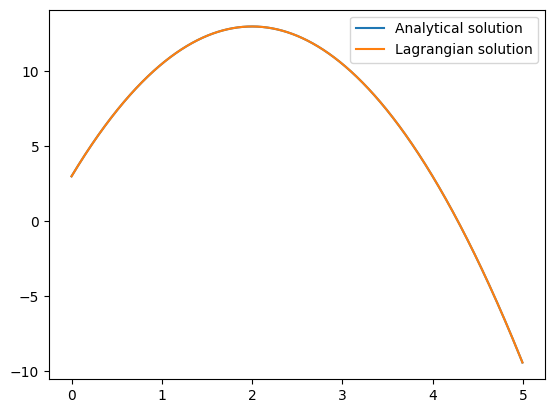

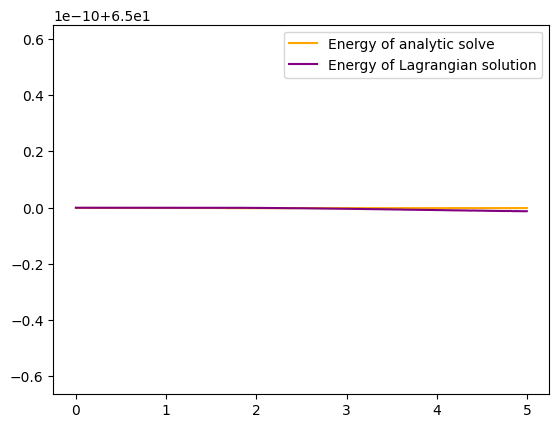

In [11]:
particle.plot_solved_dynamics(t, path, "Analytical solution")
particle.plot_solved_dynamics(t, tpath.detach(), "Lagrangian solution")
plt.legend()
plt.show()

En = [particle.energy(x) for x in path]
Ent = [particle.energy(x) for x in tpath.detach()]

plt.plot(t, En, color='orange', label='Energy of analytic solve')
plt.plot(t, Ent, color='purple', label= 'Energy of Lagrangian solution')
plt.legend()
plt.show()

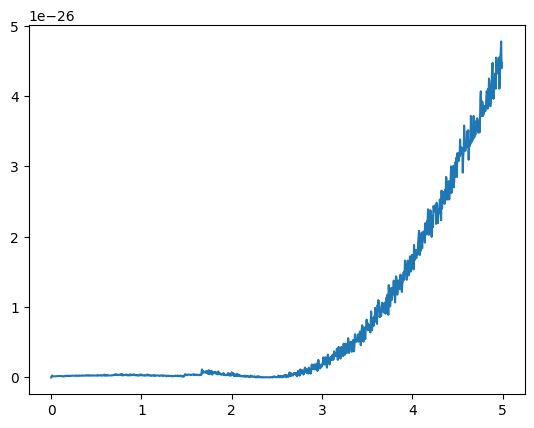

In [12]:
# Mean square difference between analytical straight solution and analytical Lagrangian solution.

plt.plot(t, np.sum((tpath.detach().numpy() - path)**2, axis=1))

In [13]:
#def rk4_step(f, x, t, h):
  # one step of runge-kutta integration
#  k1 = h * f(x, t)
#  k2 = h * f(x + k1/2, t + h/2)
#  k3 = h * f(x + k2/2, t + h/2)
#  k4 = h * f(x + k3, t + h)
#  return x + 1/6 * (k1 + 2 * k2 + 2 * k3 + k4)

In [14]:
def random_initialize(start=0, end=10, dim=2, distribution='uniform'):
    if distribution == 'uniform':
        positions = np.random.uniform(start, end, size=(dim,))
        return positions
    if distribution == 'gaussian':
        mean = (start + end) / 2  # Mean of the Gaussian distribution
        std_dev = (end - start) / (2 * np.sqrt(3))  # Standard deviation of the Gaussian distribution
        positions = np.random.normal(mean, std_dev, size=(dim,))
        # Clip values to ensure they fall within the specified range
        positions = np.clip(positions, start, end)
        return positions
    else:
        raise ValueError("Invalid distribution type. Please choose 'uniform' or 'gaussian'.")

In [15]:
#starting_positions = random_initialize(0,10)
starting_positions = particle.toy_position_example
starting_velocities = particle.toy_velocity_example
#starting_velocities = random_initialize(0, 2, 2, 'gaussian')


In [16]:
t_start = 0 
t_end = 20
total_data_points = 3000

In [17]:
t_total = torch.tensor(np.linspace(t_start, t_end, total_data_points)).float()

train_indices = torch.randperm(total_data_points)
t_train = t_total[train_indices]

tstep = t_total[1].item() 

In [18]:
#q_train is still only considering only the same system with the same phase space!

q_qdot_total = torch.tensor(ode_solve_analytic(starting_positions, starting_velocities, t_total, particle.solve_acceleration)).float()
print("State",q_qdot_total)

q_qdot_train = q_qdot_total[train_indices]
q_qdot_test = q_qdot_total



qdot_qdotdot_total = torch.tensor(analytically_differentiated_state(q_qdot_total, t_total, particle.solve_acceleration)).float()

print("Differentiated state")
print(qdot_qdotdot_total)

qdot_qdotdot_train = qdot_qdotdot_total[train_indices]


State tensor([[   3.0000,   10.0000],
        [   3.0666,    9.9667],
        [   3.1329,    9.9333],
        ...,
        [-795.8000,  -89.9333],
        [-796.4000,  -89.9667],
        [-797.0000,  -90.0000]])
Differentiated state
tensor([[ 10.0000,  -5.0000],
        [  9.9667,  -5.0000],
        [  9.9333,  -5.0000],
        ...,
        [-89.9333,  -5.0000],
        [-89.9667,  -5.0000],
        [-90.0000,  -5.0000]])


In [27]:
class LNN(nn.Module):
    def __init__(self, input_size):
        super(LNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)
    
    def lagrangian(self, x): 
        x = F.softplus(self.fc1(x))
        x = F.softplus(self.fc2(x))
        x = self.fc3(x)
        return x 

    def forward(self, x):
        n = x.shape[1]//2
        xv = torch.autograd.Variable(x, requires_grad=True)
        xv_tup = tuple([xi for xi in x]) 

        #xv_tup is tuple of "states" in various time frames.
        tqt = xv[:, n:]

        jacpar = partial(jacobian,  self.lagrangian, create_graph=True)
        hesspar = partial(hessian,  self.lagrangian, create_graph=True)

        A = tuple(map(hesspar, xv_tup))
        B = tuple(map(jacpar, xv_tup))
        
        #Why tuple?

        #print("A:", A)
        
        multi = lambda Ai, Bi, tqti, n:  torch.pinverse(Ai[n:, n:]) @ (Bi[:n, 0] - Ai[n:, :n] @ tqti) 
        multi_par = partial(multi, n=n)

        tqtt_tup = tuple(map(multi_par, A, B, tqt))
        tqtt = torch.cat([tqtti[None] for tqtti in tqtt_tup])

        xt = torch.cat([tqt, tqtt], axis=1)
        xt.retain_grad()
        return xt

    def t_forward(self, t, x):
        return self.forward(x)
    
    def plot_lagrangian(self, x):
        return self.lagrangian(torch.Tensor(x)).detach()

def loss(pred, targ):
    return torch.mean((pred - targ)**2)
 

In [20]:
def nn_solve_ode(model, x0, t):
    x0 = x0.detach().numpy()
    def f(x, t):
        x_tor = torch.tensor(np.expand_dims(x, 0), requires_grad=True).float()
        return np.squeeze(model(x_tor).detach().numpy(), axis=0)
    return odeint(f, x0, t, full_output=1) 

In [28]:
eps = 100
N = 1500 
batch_size = 100 

model = LNN(particle.dof)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_list = []
for e in range(eps):
    running_loss = 0.
    for i in range(1, N // batch_size):
        optimizer.zero_grad()
        xi = q_qdot_train[(i-1)*batch_size:i*batch_size]
        xdot_xdotdot_pred = model(xi)

        loss_val = loss(xdot_xdotdot_pred, qdot_qdotdot_train[i])
        loss_val.backward()

        optimizer.step()

        running_loss += loss_val.item()

    print('Epoch %d loss: %.10f' % (e + 1, running_loss/N))
    loss_list.append(running_loss/N)
        
        

Epoch 1 loss: 61991264.7447695285
Epoch 2 loss: 12920955.1436979175
Epoch 3 loss: 1283.1741930339
Epoch 4 loss: 54327.5463645833
Epoch 5 loss: 13216.5064542236
Epoch 6 loss: 30.4776489258
Epoch 7 loss: 28.2550315755
Epoch 8 loss: 23.9182113444
Epoch 9 loss: 22.4009378255
Epoch 10 loss: 21.9220606283
Epoch 11 loss: 21.7199142253
Epoch 12 loss: 21.5790035807
Epoch 13 loss: 21.4445906576
Epoch 14 loss: 21.3029851074
Epoch 15 loss: 21.1500576986
Epoch 16 loss: 20.9839611003
Epoch 17 loss: 20.8033143717
Epoch 18 loss: 20.6068920085
Epoch 19 loss: 20.3934938151
Epoch 20 loss: 20.1620048014
Epoch 21 loss: 19.9114078776
Epoch 22 loss: 19.6409521484
Epoch 23 loss: 19.3503563639
Epoch 24 loss: 19.0398064779
Epoch 25 loss: 18.7102641602
Epoch 26 loss: 18.3636130371
Epoch 27 loss: 18.0026523438
Epoch 28 loss: 17.6312425130
Epoch 29 loss: 17.2541601562
Epoch 30 loss: 16.8769582520
Epoch 31 loss: 16.5055352376
Epoch 32 loss: 16.1455008952
Epoch 33 loss: 15.8017402344
Epoch 34 loss: 15.4780595703
Epo

In [ ]:
torch.save(model, '/kaggle/working/model_april29.pt')

In [ ]:
#model = torch.load('/kaggle/input/first_model_lnn/pytorch/first/1/model.pt')
#model.eval()

In [ ]:
print(t_total.shape)

In [29]:

#t_test should be either decreasing or increasing!!!

nn_test = nn_solve_ode(model, q_qdot_test[0], t_total)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5158612023022D+00   r2 =  0.5011945483121D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5158612023022D+00   r2 =  0.5011945483121D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5158612023022D+00   r2 =  0.5011945483121D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5158612023022D+00   r2 =  0.5011945483121D-16
 lsoda--  warning..internal t (=r1) 

/tmp/ipykernel_34/1642044099.py:6: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  return odeint(f, x0, t, full_output=1)


(array([[3.00000000e+00, 1.00000000e+01],
       [3.06703113e+00, 1.01029501e+01],
       [3.13475588e+00, 1.02080472e+01],
       ...,
       [8.19913427e+67, 7.44333860e+67],
       [3.26196463e+71, 2.37045620e+64],
       [1.23018203e+66, 1.36929786e+66]]), {'hu': array([2.07547739e-003, 1.74251633e-003, 5.47449266e-003, ...,
       6.32404027e-322, 6.32404027e-322, 0.00000000e+000]), 'tcur': array([8.17266058e-03, 1.34002096e-02, 2.41022512e-02, ...,
       6.04290714e+64, 4.72576139e+75, 7.17005665e+77]), 'tolsf': array([4.91872412e-310, 4.91872412e-310, 4.91872412e-310, ...,
       6.64083315e+066, 2.56411380e+070, 5.04016859e+066]), 'tsw': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       7.06284136e+67, 8.22969075e+62, 5.85361050e+65]), 'nst': array([         10,          15,          19, ..., -1264692288,
             23179,           0], dtype=int32), 'nfe': array([         21,          35,          43, ...,           0,
                 0, -1258980208], dtyp

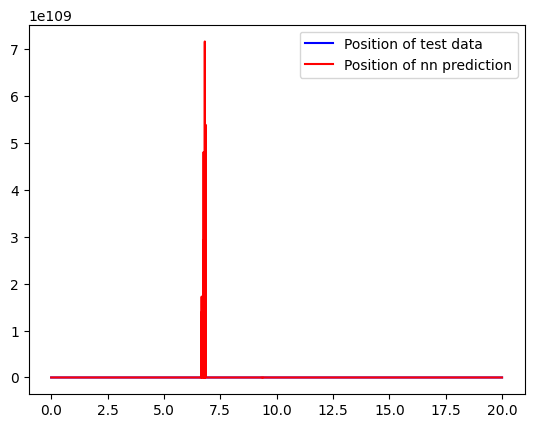

In [30]:
plt.plot(t_total, q_qdot_test[:, 0], color='blue', label='Position of test data')
print(nn_test)
plt.plot(t_total, nn_test[0][:, 0], color='red', label='Position of nn prediction')
plt.legend()
plt.show()
#plt.plot(np.arange(len(loss_list)), loss_list)
#plt.yscale('log')


In [31]:
for i in range(100):
    print((nn_test[0][i], q_qdot_test[i]))

(array([ 3., 10.]), tensor([ 3., 10.]))
(array([ 3.06703113, 10.10295005]), tensor([3.0666, 9.9667]))
(array([ 3.13475588, 10.20804724]), tensor([3.1329, 9.9333]))
(array([ 3.20318878, 10.31534963]), tensor([3.1991, 9.9000]))
(array([ 3.27234478, 10.42491768]), tensor([3.2650, 9.8666]))
(array([ 3.34223922, 10.53681396]), tensor([3.3307, 9.8333]))
(array([ 3.41288784, 10.65110361]), tensor([3.3961, 9.7999]))
(array([ 3.48430677, 10.76785409]), tensor([3.4614, 9.7666]))
(array([ 3.55651269, 10.88713587]), tensor([3.5264, 9.7332]))
(array([ 3.62952277, 11.00902233]), tensor([3.5912, 9.6999]))
(array([ 3.70335456, 11.13358954]), tensor([3.6558, 9.6666]))
(array([ 3.77802623, 11.26091694]), tensor([3.7201, 9.6332]))
(array([ 3.85355656, 11.39108737]), tensor([3.7843, 9.5999]))
(array([ 3.9299646 , 11.52418674]), tensor([3.8482, 9.5665]))
(array([ 4.0072703 , 11.66030505]), tensor([3.9119, 9.5332]))
(array([ 4.08549407, 11.79953601]), tensor([3.9753, 9.4998]))
(array([ 4.16465702, 11.941977

/tmp/ipykernel_34/2500236381.py:12: RuntimeWarning: overflow encountered in scalar power
  return 0.5 * self.m * x[1]**2


ValueError: Axis limits cannot be NaN or Inf

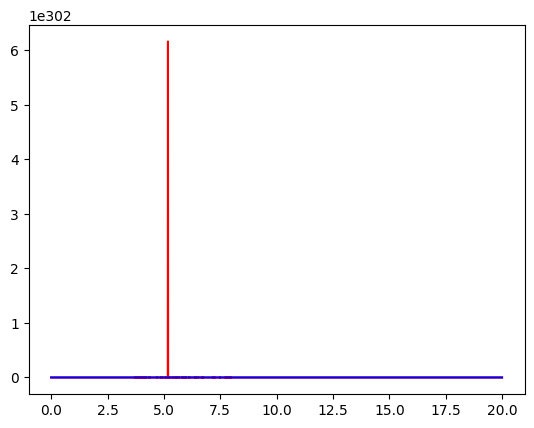

In [24]:
E_test = [particle.energy(x) for x in q_qdot_test]
E_lnn = [particle.energy(x) for x in nn_test[0]]

plt.plot(t_total, E_lnn, color='red', label='E_lnn')
plt.plot(t_total, E_test, color='blue', label='E_train')


plt.ylim(min(min(E_test), min(E_lnn))-0.02, max(max(E_test), max(E_lnn)))
plt.legend()

plt.show()

tensor([[-2.9405],
        [-2.6898],
        [-2.5188],
        ...,
        [-0.3231],
        [-0.3231],
        [-0.3231]], grad_fn=<AddmmBackward0>)


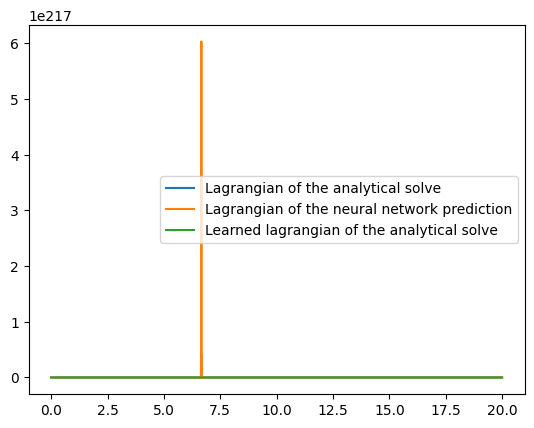

In [32]:
# Plotting lagrangians

particle.plot_lagrangian(t_total, q_qdot_test, particle.lagrangian, "Lagrangian of the analytical solve")
particle.plot_lagrangian(t_total, nn_test[0], particle.lagrangian, "Lagrangian of the neural network prediction")
particle.plot_lagrangian(t_total, q_qdot_test, model.plot_lagrangian, "Learned lagrangian of the analytical solve")
plt.legend()
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

def Lagr(x, g=10, k=10):
    q, qt = torch.split(x, 2)
    T = 0.5*(qt[0]**2 + (q[0]*qt[1])**2)
    V = g*q[0]*(1-torch.cos(q[1])) + k*(q[0] - 1)**2
    return T - V 


def Lagr(x,y):
    q, qt = x, y
    T = 0.5*(qt[0]**2 + (q[0]*qt[1])**2)
    V = g*q[0]*(1-torch.cos(q[1])) + k*(q[0] - 1)**2
    return T - V 

# Generate x and y values
x = q_qdot_total[:,0]
print(x)
y = q_qdot_total[:,1]
print(torch.stack((x,y),1))
X, Y = torch.meshgrid(x,y)
Z = Lagr(X, Y)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(X, Y, Z, cmap='viridis')

# Add labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('f(x, y)')
ax.set_title('Surface Plot of f(x, y)')

# Add color bar
fig.colorbar(surf)

# Show the plot
plt.show()
